In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/mentorchains/level1_post_recommender_20/md2/webScraping_EDA_tutorials/FLOWSTER_SCRAPED_DATA20201212224954.csv'
data = pd.read_csv(url,index_col=0)

In [2]:
data.head(3)

,Topic Title,Category,Tags,Leading Post,Post Replies,Created_at,Likes,Views,Replies
0,About the Store & Website Management category,Store & Website Management,[],Have questions about Store & Website Managemen...,[],0,0,0,0
1,Securing long term partnerships,Store & Website Management,[],"Hello, I just closed a deal to manage a quite ...",['Brand management is going to have partner tu...,"Dec 5, 2020 5:49 pm",0,19,1
2,Amazon Free Products,Store & Website Management,[],"Hello,\nI need some buyers for my products in ...",[],0,0,0,0


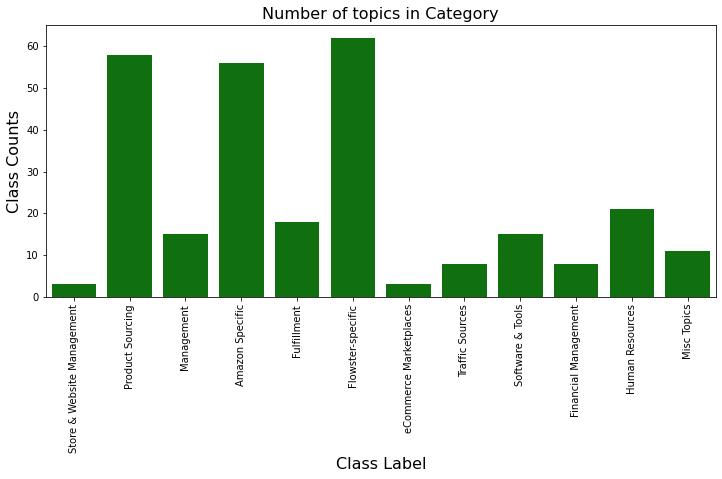

In [3]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.countplot(x=data.Category, color='green')
plt.title('Number of topics in Category', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

# 1. Content-based recommender 

#Word embedding word2vec
#Continuous Bag-of-Words model (CBOW): predict words given the context of a few words before & after the target word. 
#TF-IDF or ( Term Frequency(TF) — Inverse Dense Frequency(IDF) 

#spaCy contains many dataset of word embedding
#import spacy
#import en_core_web_sm
#nlp = en_core_web_sm.load()

#PyTorch: 
    #provides modules and classes to create and train neural networks. 
    #provides methods to create random or zero-filled tensors (~matrix), 
        #which will be used to create  weights and bias for a simple linear model. 
#torch rather than numpy arrays, pytorch convert our data.
#import torch
#import math

In [4]:
#Recommend Topic Title based on Leading Post 
data['Leading Post'].head(5)

0    Have questions about Store & Website Managemen...
1    Hello, I just closed a deal to manage a quite ...
2    Hello,\nI need some buyers for my products in ...
3    Have questions about sourcing products? This i...
4    Hello Bright Ideas Tribe,\nI would like to giv...
Name: Leading Post, dtype: object

In [5]:
#compute Term Frequency-Inverse Document Frequency (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

#Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

In [6]:
#Replace NaN with an empty string
data['Leading Post'] = data['Leading Post'].fillna('')

In [7]:
#Construct TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['Leading Post'])

tfidf_matrix.shape

(278, 2514)

In [8]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[1:10]

['01', '052640_bluemail', '10', '100', '100k', '103', '10k', '117', '12']

In [9]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(278, 278)

In [10]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(data.index, index=data['Topic Title']).drop_duplicates()

In [11]:
#10 most similar categories
indices[:10]

Topic Title
About the Store & Website Management category         0
Securing long term partnerships                       1
Amazon Free Products                                  2
About the Product Sourcing Category                   3
Virtual Assistant sending Emails Hubspot              4
China sourcing                                        5
Virtual Assistant Using Email                         6
Can I return stock that doesn’t sell?                 7
How to get a Reseller Permit in USA as a Canadian?    8
Video in your Email                                   9
dtype: int64

In [12]:
#Recommendation function

def get_recommendations(Topic, cosine_sim=cosine_sim):
    #1. Get the index crp. to category
    idx = indices[Topic]
    
    #2. Get similarity score to all movies
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    #3. Sort by similarity scores
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)
    
    #4. 10 most similar categories
    sim_scores = sim_scores[1:11]
    
    #5. Get Category indices
    topic_indices = [i[0] for i in sim_scores]
    
    return data['Topic Title'].iloc[topic_indices]

In [13]:
get_recommendations('Securing long term partnerships')

47                                            References
42              Hubspot - Whose account does the VA use?
11             Top 10 Tips to Grow your Business Rapidly
105                  Wholesale VS Agency business model?
71                       EFT Call Summary for Dec 4 2019
112               Brand Registry Registered Agent Issues
131                               Long Term Storage Fees
128       When to Pull Fulfillable Amazon FBA Inventory?
56     How Do I Convince Suppliers to Give Me a 20%+ ...
226                                      Hubspot Changes
Name: Topic Title, dtype: object

In [14]:
get_recommendations('Video in your Email')

45                                    Getting Video Chat
157                                  Cold Email Outreach
23                                  Sending Gmass Emails
224                           Email Account Organization
25                            Sending Mass email - Gmass
6                          Virtual Assistant Using Email
205                                       WEBS community
74     eCommerce Fast Track Mastermind Call Summary f...
39     Paid For LinkedIn with Sales Navigator and Snovio
253       What email should be used for VA software use?
Name: Topic Title, dtype: object

# 2. Text classifier
Topic Title	Category	Tags	Leading Post	Post Replies	Created_at	Likes	Views	Replies

In [15]:
#use the .copy() method to ensure that the new DataFrame created is independent of your original metadata
data_text = data.copy()

In [16]:
data_text.drop(columns=['Created_at','Likes','Views','Replies'],inplace=True)

In [17]:
data_text['text'] = data_text['Topic Title'] + ' ' + data_text['Category'] + ' ' + data_text['Tags'] +' ' + data_text['Leading Post'] + ' ' + data_text['Post Replies']

In [18]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

#data cleaning

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [19]:
data_text.iloc[3,3]

'Have questions about sourcing products? This is the category to use. Please be sure to select the most appropriate sub-category for your questions.'

In [20]:
clean_text(data_text.iloc[3,3])

'question sourc product categori us sure select appropri sub categori question'

In [21]:
from wordcloud import WordCloud

In [22]:
text = data_text['Leading Post'][1]

In [23]:
print(text)

Hello, I just closed a deal to manage a quite large brand account on Amazon, my main concern now is that this partnership may only last 1-2 years and once the account has grown to higher levels they would just manage it by themselves. What methods, tips and tricks you can suggest to protect this deal and make sure they will stick with my company managing their account for long term? Essentially how can I make them dependent on me so it will be very hard for them to let go our partnership?


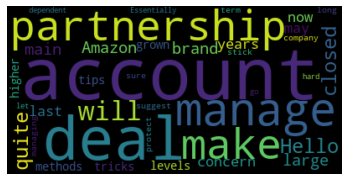

In [24]:
#wordcloud for 1st leading post
cloud = WordCloud().generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
# combine all leading posts

posts = "".join(post for post in data_text['Leading Post'])
print ("There are {} words in the combination of all review.".format(len(posts)))

There are 113445 words in the combination of all review.


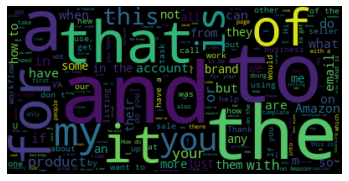

In [26]:
wordcloud = WordCloud(max_font_size=100,stopwords='english').generate(posts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()                                                 

In [27]:
#cleaning all leading posts 
clean_word = clean_text(posts)
print ("There are {} words in the combination of all review.".format(len(clean_word)))

There are 51613 words in the combination of all review.


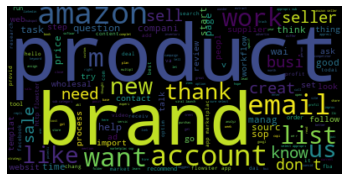

In [28]:
wordcloud = WordCloud(max_font_size=100,stopwords='english').generate(clean_word)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()  

In [29]:
#Wordcloud of Leading post for each category
data_text.rename(columns={"Category": "category"}, inplace=True)
df =data_text[['category','Leading Post']]

In [30]:
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [31]:
df.head(2)

,category,Leading Post
0,Store & Website Management,Have questions about Store & Website Managemen...
1,Store & Website Management,"Hello, I just closed a deal to manage a quite ..."


In [32]:
# plot wordcloud of leading post in each category
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df['category'] == str(category)]
    post_df = "".join(post for post in text_df['Leading Post'])
    print ("There are {} words in the combination of all review.".format(len(posts)))
    plot_word_cloud(post_df)

In [33]:
df.category.unique()

array(['Store & Website Management', 'Product Sourcing', 'Management',
       'Amazon Specific', 'Fulfillment', 'Flowster-specific',
       'eCommerce Marketplaces', 'Traffic Sources', 'Software & Tools',
       'Financial Management', 'Human Resources', 'Misc Topics'],
      dtype=object)

There are 113445 words in the combination of all review.


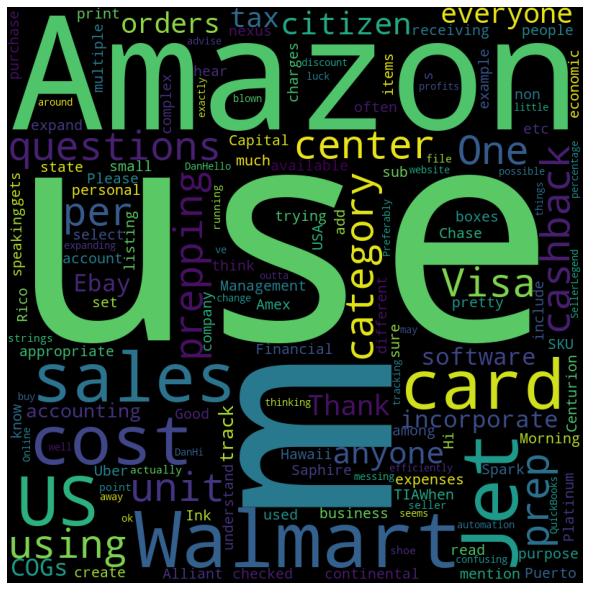

In [34]:
plot_word_cloud_for_category(df, 'Financial Management')

There are 113445 words in the combination of all review.


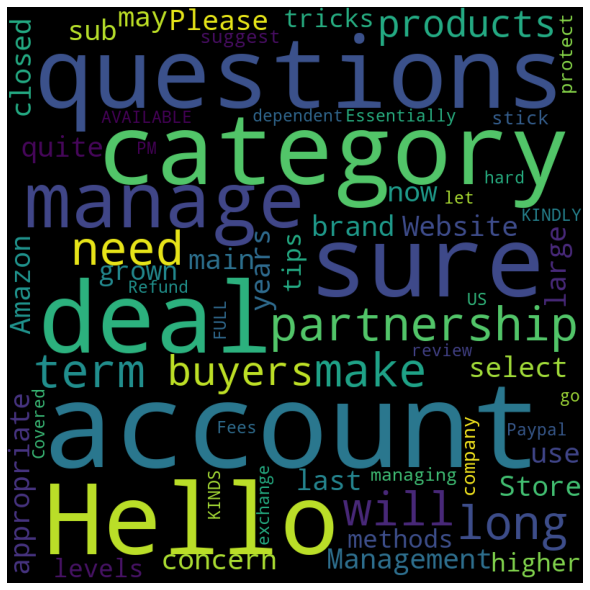

In [35]:
plot_word_cloud_for_category(df, 'Store & Website Management')